<a href="https://colab.research.google.com/github/geedoubledee/data620_week8assignment/blob/main/DATA620_Week8_Assignment_GDavis_BDavidoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA620: Week 8 Assignment
#### by Glen Davis and Brett Davidoff

In [15]:
import math
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import brown
from nltk.probability import FreqDist
import numpy as np
import pandas as pd
import requests
from scipy.interpolate import make_interp_spline
import string
import tempfile
import textwrap as tw

We create a corpus of three of Bram Stoker's horror novels: DRACULA, THE JEWEL OF SEVEN STARS, and THE LAIR OF THE WHITE WORM, and we record the frequency distribution for all unique words.

In [16]:
base = "https://raw.githubusercontent.com/geedoubledee/data620_week8assignment/main/"
exts = ["BramStoker_Dracula.txt", "BramStoker_TheJewelofSevenStars.txt", "BramStoker_TheLairoftheWhiteWorm.txt"]
def create_fdist_from_corpus(base, exts):
    with tempfile.TemporaryDirectory() as tmpdirn: # creates temporary directory
        for ext in exts:
            resp = requests.get(base + ext)
            with tempfile.NamedTemporaryFile(mode = "r+", encoding = "UTF-8",
                                             suffix = "_" + ext, delete = False,
                                             dir = tmpdirn) as tmpfn: # creates named temporary .txt files
                content = []
                ind = -1
                for line in resp.text.splitlines():
                    ind += 1
                    content.append(line)
                    if line.strip().startswith("*** START"):
                        start = ind + 1
                    elif line.strip().startswith("*** END"):
                        end = ind
                        tmpfn.writelines(content[start:end]) # writes lines for trimmed content
                    else:
                        continue
                tmpfn.close() # the file is closed, but not removed
        patt = r".*\.txt$"
        corpus = PlaintextCorpusReader(root = tmpdirn, fileids = patt) # creates corpus from named temporary .txt files
        fdist = nltk.FreqDist(w.lower() for w in corpus.words())
        total_words = len(corpus.words())
        unique_words = len(fdist)
        summ = {"total_words": total_words,
                "unique_tokens": unique_words}
        print(summ)
    # directory and its contents have now been removed
    return fdist
bram_stoker_fdist = create_fdist_from_corpus(base, exts)

{'total_words': 341739, 'unique_tokens': 25781}


There are 25,781 unique tokens in the corpus without doing any clean-up, but we can reduce this word count by removing stand-alone punctuation tokens and replacing any numeric tokens with a single "0.0" token.

In [17]:
def remove_punct_tokens(freq_dist):
    str_punct = "".join([c for c in string.punctuation] + [u'\u201c', u'\u201d', u'\u2018', u'\u2019'])
    punct = []
    for k in freq_dist.keys():
        try:
            for c in k:
                ind = str_punct.index(c)
            punct.append(k) # key is single punct or composed entirely of punct
        except:
            continue
    for p in punct:
        freq_dist.pop(p)
    print(f"\nPunctuation tokens removed: \n")
    wrapped = tw.fill(str(punct))
    print(wrapped)
    return None
remove_punct_tokens(bram_stoker_fdist)


Punctuation tokens removed: 

['’', '-', '“', '”', ';', ',', '.', '....', '.“', '?”“', '.”“', '!”',
':“', '!', '.”', '?', ',”', '!“', '!”“', ':', '....”', '?”', '...”',
'&', '‘', '!’”', ',“', '?”“‘', ',’', '.’“', '!’', '”;', '”.', '...',
'?’', '!’”“', '...!', '’,', ':“‘', '!’“', '.‘', '’.', '.’', '’.“',
'.’“‘', '.“‘', '?’“‘', '!’“‘', '”,', '.’”', '!’”“‘', '!...”', '’;',
'’?', '.’...', '”:', '“‘', '...!”', '.*', '*', '[', ']', '_', '(',
')', '--', '.,', '.)', ':--', '.--', '”--', '--“', ':--“', '!”--“',
'!”--', '”:--', '(“', '.”)', ',--', '!--', ',‘', ',--“', '???”',
'?--', '----', ':--“‘', '?’“', '.(', '?)', '’-', ').', ',...', '),',
'{', '}', '!...“', '’--', '--‘', '*“', '....“', '*...', '!”’',
'----”', '.“’', '“’', ':‘', '!“‘', '-’', '.)“', ';“', '----”;', '.,’',
')“', '----”“', '.’”“', '”--“', ';”', '--!', '--”', '’.”', '--?',
'__', '?----', '’?”', '----!”', '?...', '----!', '!...', '@', "'",
'."', ',"', '"', '."*', '!"', '.""', '!""', '?""', ':"', ",'", '?"',
".'", "'--", '"--', '

In [18]:
def replace_num_tokens(freq_dist):
    nums = []
    freqs = []
    for k, v in freq_dist.items():
        try:
            num = float(k)
            nums.append(k)
            freqs.append(v)
        except:
            continue
    for n in nums:
        freq_dist.pop(n)
    freq_dist["0.0"] = sum(freqs)
    print("\nNumeric tokens replaced with '0.0' token: \n")
    wrapped = tw.fill(str(nums))
    print(wrapped)
    return None
replace_num_tokens(bram_stoker_fdist)


Numeric tokens replaced with '0.0' token: 

['1650', '1884', '31', '1897', '8', '35', '6', '46', '7', '30', '13',
'000', '16', '12', '19', '59', '1854', '20', '1777', '50', '29',
'1873', '2', '33', '18', '11', '4', '14', '17', '3', '9', '10', '1',
'24', '28', '25', '34', '5', '347', '45', '40', '70', '500', '1911',
'1860']


In [19]:
total_words = sum(bram_stoker_fdist.values())
unique_words = len(bram_stoker_fdist)
summ = {"total_words": total_words,
         "unique_tokens": unique_words}
print(summ)

{'total_words': 292338, 'unique_tokens': 25585}


That leaves us with 25,585 unique tokens and 292,338 total words remaining in the corpus.

In [20]:
# Sort the frequency distribution in descending order
bram_stoker_fdist_sorted = dict(sorted(bram_stoker_fdist.items(), key = lambda x:x[1], reverse = True))
def find_pth_percentile(sorted_freq_dist, p=0.5): # Sum frequencies of most common words until 2nd quartile
    cutoff = math.ceil(sum(sorted_freq_dist.values()) * p)
    cumsum = 0
    keys = []
    for k, v in sorted_freq_dist.items():
        if cumsum + v < cutoff:
            cumsum += v
            keys.append(k)
        else:
            break
    return {"k_n": len(keys), # Dict contains count/list of tokens prior to 2nd quartile
            "k_list": keys}
perc_50 = find_pth_percentile(bram_stoker_fdist_sorted, p=0.5)
k_n = perc_50["k_n"]
k_list = perc_50["k_list"]
print(f"Half of the total words in the corpus are taken up by the {k_n} most common tokens: \n")
wrapped = tw.fill(str(k_list))
print(wrapped)

Half of the total words in the corpus are taken up by the 73 most common tokens: 

['the', 'and', 'to', 'of', 'i', 'a', 'in', 'that', 'he', 'it', 'was',
'as', 'for', 'you', 'is', 'had', 'his', 'we', 'with', 'not', 'her',
'me', 'on', 'all', 'at', 'be', 'but', 'my', 'she', 'have', 'so',
'which', 'there', 'him', 'when', 's', 'this', 'from', 'were', 'or',
'if', 'by', 'one', 'said', 'then', 'are', 'could', 'no', 'what',
'they', 'been', 'would', 'up', 'some', 'out', 'us', 'do', 'them',
'will', 'an', 'time', 'may', 'now', 'know', 'more', 'any', 'see',
'can', 'must', 'our', 'over', 'came', 'shall']


The 73 tokens that take up half the space in the corpus are very common English words that don't reveal much about this particular text. We might remove these stopwords from consideration in other analysis, but here we leave them in so we can make some comparisons with another corpus later.

Now we take a look at the top 200 words in the corpus.

In [21]:
top_200_words = list(bram_stoker_fdist_sorted.keys())[:200] # Extract the top 200 words
print("\nThe top 200 words in the corpus are: \n") # Print the top 200 words
wrapped = tw.fill(str(top_200_words))
print(wrapped)


The top 200 words in the corpus are: 

['the', 'and', 'to', 'of', 'i', 'a', 'in', 'that', 'he', 'it', 'was',
'as', 'for', 'you', 'is', 'had', 'his', 'we', 'with', 'not', 'her',
'me', 'on', 'all', 'at', 'be', 'but', 'my', 'she', 'have', 'so',
'which', 'there', 'him', 'when', 's', 'this', 'from', 'were', 'or',
'if', 'by', 'one', 'said', 'then', 'are', 'could', 'no', 'what',
'they', 'been', 'would', 'up', 'some', 'out', 'us', 'do', 'them',
'will', 'an', 'time', 'may', 'now', 'know', 'more', 'any', 'see',
'can', 'must', 'our', 'over', 'came', 'shall', 'went', 'who', 'room',
'into', 'such', 'has', 'come', 'did', 'am', 'only', 'seemed', 'mr',
'like', 'your', 'man', 'way', 'before', 'even', 'well', 'night',
'though', 'back', 'made', 'again', 'hand', 'here', 'than', 'about',
'go', 'own', 'very', 't', 'down', 'after', 'great', '—', 'where',
'took', 'other', 'door', 'trelawny', 'good', 'once', 'how', 'think',
'should', 'their', 'through', 'old', 'too', 'eyes', 'much', 'face',
'looked', 'van', '

We start to see words that are more meaningful to this particular corpus, including proper nouns. "Van" and "Helsing" both appear, and the pairwise correlation for these tokens is probably close to 1 since these tokens together represent the last name of a central character in DRACULA. It's no surprise to see "night," "fear," and "strange" stand out as very common as well since our corpus is composed entirely of horror fiction novels.

We plot the relative frequencies of the top 200 words.

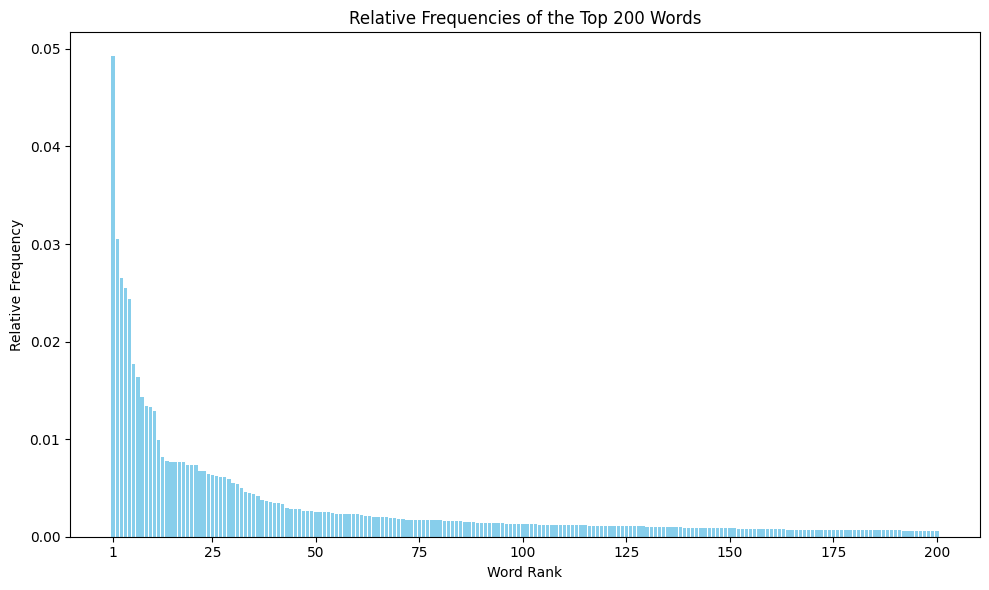

In [22]:
# Create a graph that shows the relative frequencies of the top 200 words
top_200_freq = [bram_stoker_fdist_sorted[word] for word in top_200_words]
top_200_rel_freq = [x / total_words for x in top_200_freq]
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_200_words)), top_200_rel_freq, color='skyblue')
plt.xlabel('Word Rank')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequencies of the Top 200 Words')
plt.xticks(ticks = [0] + list(range(24, 224, 25)), labels = [1] + list(range(25, 225, 25)))
plt.tight_layout()
plt.show()

Zipf's law states that the frequency of a word in a corpus is inversely proportional to its rank in the frequency table. We plot the log of the word rank versus the log of the frequency to see if Zipf's law holds for the top 200 words in this corpus.

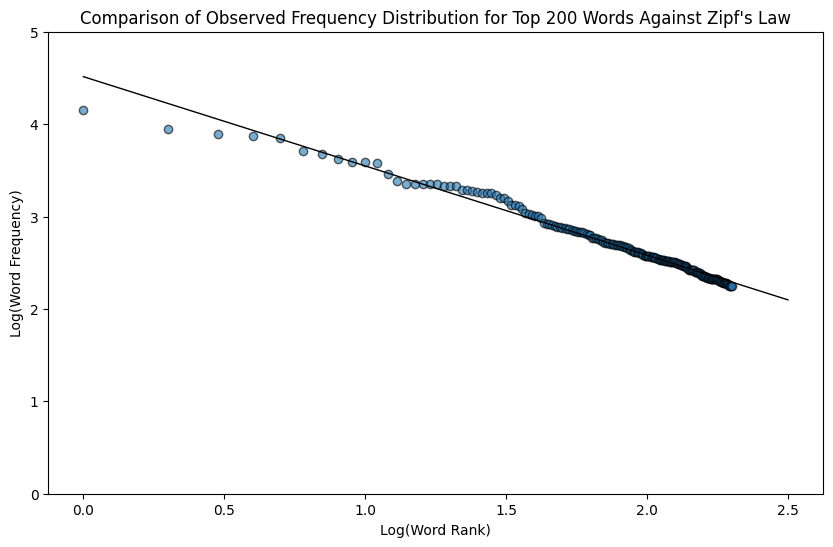

In [23]:
zipf_df = pd.DataFrame({"word": top_200_words,
           "freq": top_200_freq})
zipf_df["rank"] = range(1, len(zipf_df) + 1)
zipf_df["logfreq"] = np.log10(zipf_df["freq"])
zipf_df["logrank"] = np.log10(zipf_df["rank"])
plt.figure(figsize=(10, 6))
plt.scatter(zipf_df["logrank"], zipf_df["logfreq"], alpha = 0.6, edgecolors = "black")
b, a = np.polyfit(zipf_df["logrank"], zipf_df["logfreq"], deg=1)
xseq = np.linspace(0, 2.5, num=100)
plt.plot(xseq, a + b * xseq, color="black", lw=1)
plt.ylim(0, 5)
plt.xlabel('Log(Word Rank)')
plt.ylabel('Log(Word Frequency)')
plt.title("Comparison of Observed Frequency Distribution for Top 200 Words Against Zipf's Law")
plt.show()

There is always some deviation from the ideal Zipf's distribution line, but the distribution of the top 200 words in the corpus does follow Zipf's law for the most part. We see frequency decreasing as an inverse function of rank, as we expected.

Finally, we compare the frequency distribution of the Bram Stoker corpus to that of the Brown corpus to find the shared words with the biggest relative frequency differences.

In [24]:
# Download and load words from Brown corpus for comparative purposes
nltk.download('brown', quiet = True)
brown_words = brown.words()
total_words_brown = len(brown_words) # Calc total words: brown corpus for freq normalization
fdist_brown = FreqDist(w.lower() for w in brown_words if w.isalpha()) # Calc freq dist: brown corpus
# Normalize both freq dists
brown_freq_norm = {word: freq / total_words_brown for word, freq in fdist_brown.items()}
stoker_freq_norm = {word: freq / total_words for word, freq in bram_stoker_fdist_sorted.items()}
# Compare the relative frequencies of the same words in both corpora
common_words = set(brown_freq_norm.keys()) & set(stoker_freq_norm.keys())
comparison_dict = { # Build a comparison dictionary
    word: {
        'Brown': brown_freq_norm[word],
        'Stoker': stoker_freq_norm[word],
        'Difference': stoker_freq_norm[word] - brown_freq_norm[word]
    }
    for word in common_words
}
# Sort the words by the largest difference in frequency between corpora
sorted_comparison = sorted(comparison_dict.items(), key=lambda x: abs(x[1]['Difference']), reverse=True)
# Print the top 5 words that differ the most
for word, data in sorted_comparison[:5]:
    print(f"Word: {word}\nBrown Frequency: {data['Brown']}\nStoker Frequency: {data['Stoker']}\nDifference: {data['Difference']}\n")

Word: i
Brown Frequency: 0.004447154303508808
Stoker Frequency: 0.024382735053260267
Difference: 0.019935580749751457

Word: the
Brown Frequency: 0.06025790739171472
Stoker Frequency: 0.04923410572693252
Difference: -0.011023801664782201

Word: of
Brown Frequency: 0.03135743270708031
Stoker Frequency: 0.025453413514493498
Difference: -0.005904019192586811

Word: it
Brown Frequency: 0.0075439720563007665
Stoker Frequency: 0.01329625296745548
Difference: 0.0057522809111547136

Word: me
Brown Frequency: 0.0010170583331610965
Stoker Frequency: 0.0066908852082178845
Difference: 0.005673826875056788



The pronoun "I" has the largest difference in relative frequency, occurring much more frequently in the Stoker corpus than in the Brown corpus. This reflects the first-person narrative style commonly used in Stoker's novels, in which characters often recount their own experiences.

We visualize the 20 words with the biggest relative frequency differences, including the pronoun "I."

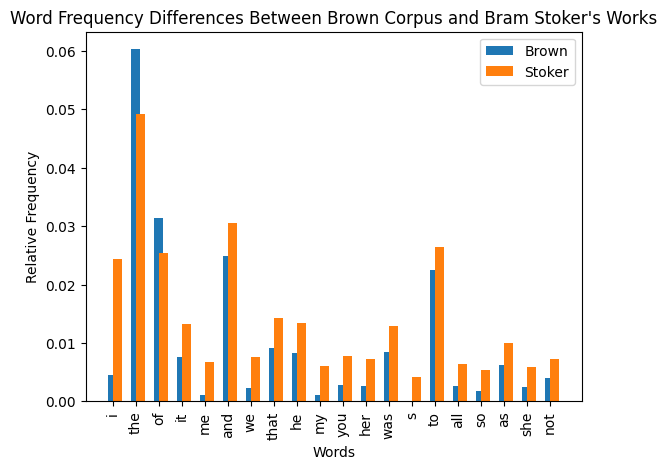

In [25]:
# Take the top 20 words for better visibility
top_diff_words = sorted_comparison[:20]
labels, brown_freqs, stoker_freqs = zip(*[(word, data['Brown'], data['Stoker']) for word, data in top_diff_words])
x = range(len(labels))
plt.bar(x, brown_freqs, width=0.4, label='Brown', align='center')
plt.bar(x, stoker_freqs, width=0.4, label='Stoker', align='edge')
plt.xlabel('Words')
plt.ylabel('Relative Frequency')
plt.title('Word Frequency Differences Between Brown Corpus and Bram Stoker\'s Works')
plt.xticks(x, labels, rotation='vertical')
plt.legend()
plt.show()

Many of the rest of these words are similar in relative frequency across both corpora, with most of them being relatively more frequent in the Stoker corpus. The words "the" and "of" are the only two words that have higher relative frequencies in the Brown corpus.